In [1]:
import numpy as np
import pandas as pd
import csv
import requests
import io
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

date                                      0
location                                  0
total_vaccinations                      400
total_distributed                       580
people_vaccinated                       592
people_fully_vaccinated_per_hundred    1214
total_vaccinations_per_hundred         1112
people_fully_vaccinated                 674
people_vaccinated_per_hundred          1137
distributed_per_hundred                1125
daily_vaccinations_raw                   65
daily_vaccinations                       65
daily_vaccinations_per_million          800
share_doses_used                        580
state                                     0
vaxxed_per_hundred                     1214
dtype: int64

(1100, 16)


C:\Users\Agent\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Text(0.5, 1.0, 'US Vaccinations')

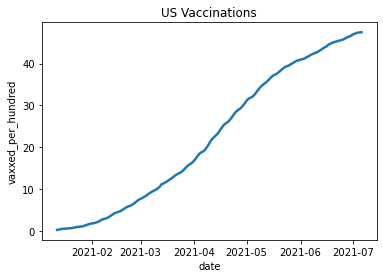

In [2]:
#Loading the initial state vaccination csv.
data = pd.read_csv('us_state_vaccinations.csv')
data['date'] = data['date'].astype('datetime64[ns]')
data['state'] = data['location']
data['vaxxed_per_hundred'] = data['people_fully_vaccinated_per_hundred']

display(data.isnull().sum())
safe = data[data['vaxxed_per_hundred'] > 45]
print(safe.shape)
#Extrapolating the needed data into a new dataframe.
cut = data.drop(columns = ['total_distributed', 'people_fully_vaccinated_per_hundred','location','people_vaccinated', 
                           'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'distributed_per_hundred'
                           , 'daily_vaccinations_raw', 'daily_vaccinations_per_million', 'share_doses_used'])

new = cut.loc[(cut['date'] == '2021-07-06')]
new.head()

us = cut.loc[(cut['state'] == 'United States')]
us['vaxxed_per_hundred'] = us['vaxxed_per_hundred'].interpolate(method='linear', limit_direction='forward')

f, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=us, x = 'date', y = 'vaxxed_per_hundred', palette="tab10", linewidth=2.5)
plt.title('US Vaccinations')

,date,state,cases_avg,cases_avg_per_100k,deaths_avg
26964,2021-07-06,Northern Mariana Islands,0.00,0.00,0.00
26965,2021-07-06,Guam,6.57,3.90,0.00
26966,2021-07-06,Puerto Rico,55.00,1.62,0.71
26967,2021-07-06,Virgin Islands,12.00,11.30,0.00
26968,2021-07-06,Wyoming,63.86,11.03,0.57


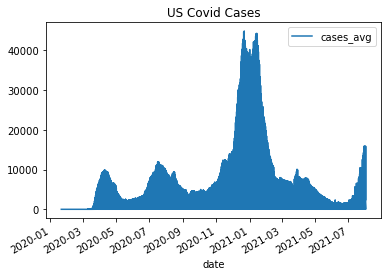

In [3]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
download = requests.get(url).content

#Creating a new dataframe for rolling average values

rolling_avg = pd.read_csv(io.StringIO(download.decode('utf-8')))

rolling_avg['date'] = pd.to_datetime(rolling_avg['date'], format='%Y-%m-%d')

#Extrapolating needed data into a new rolling average dataframe.
rolling_avg = rolling_avg.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])
rolling_avg.plot.line(x = 'date', y = 'cases_avg', title= 'US Covid Cases')
raNew = rolling_avg.loc[(rolling_avg['date'] =='2021-07-06')]
raNew.head()

In [4]:
url_2 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/07-05-2021.csv"
dl = requests.get(url_2).content

#Loading the initial dataframe for the master covid data
jH = pd.read_csv(io.StringIO(dl.decode('utf-8')))

jH['state'] = jH['Province_State']

#Extrapolating the needed data into a new dataframe
jHnew = jH.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_', 'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])

jHnew.head()

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,state
0,551298,11358,NaN,NaN,11243.671206,2.060229,Alabama
1,71384,377,NaN,NaN,9757.977978,0.528130,Alaska
2,0,0,NaN,NaN,0.000000,NaN,American Samoa
3,897010,17979,NaN,NaN,12323.737824,2.004325,Arizona
4,351825,5920,NaN,NaN,11658.311806,1.682655,Arkansas


In [5]:
#Merging 2 Dataframes together
dos = pd.merge(new, raNew, on=['state','date'])
dos
dos['date'] = pd.to_datetime(dos['date'], format='%Y-%m-%d')
#Merging the Created dataframe and the master data together
all3 = pd.merge(dos, jHnew, on='state')

all3 = all3[['date', 'state', 'vaxxed_per_hundred', 'people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 'Recovered', 
            'Active', 'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
all3['Recovered'] = all3['Confirmed'] - all3['Deaths']

#Displaying the new merged dataframe
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,NaN,11243.671206,2.060229,6066.0,3392366.0
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,NaN,9757.977978,0.528130,3219.0,678029.0
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,NaN,12323.737824,2.004325,48692.0,6826215.0
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,NaN,11658.311806,1.682655,5162.0,2261649.0
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,NaN,9671.872929,1.665545,95566.0,43182509.0


In [6]:
url_3 = "https://raw.githubusercontent.com/datasets/covid-19/main/data/us_confirmed.csv"
dl3 = requests.get(url_3).content

#adding data from a 3rd dataframe for confirmed active covid cases by state

confirmed = pd.read_csv(io.StringIO(dl3.decode('utf-8')),  error_bad_lines=False)

C:\Users\Agent\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,date,state,Active
0,2020-01-22,Alabama,0
1,2020-01-23,Alabama,0
2,2020-01-24,Alabama,0
3,2020-01-25,Alabama,0
4,2020-01-26,Alabama,0


Text(0.5, 1.0, 'US Covid Cases')

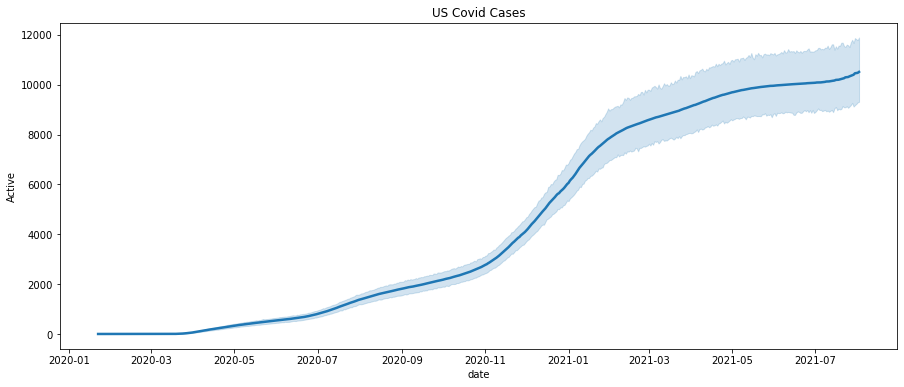

In [7]:
#Configuring the dataframe, dropping unnecessary or redundant values/changing column names to match.

confirmed['Date'] = pd.to_datetime(confirmed['Date'], format='%Y-%m-%d')
confirmed['date'] = confirmed['Date']
confirmed['state'] = confirmed['Province/State']
confirmed['Active'] = confirmed['Case']
confirmed.drop(columns=['Admin2', 'Date', 'Province/State', 'Country/Region', 'Case'], inplace=True)
display(confirmed.head())

f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=confirmed, x = 'date', y = 'Active', palette="tab10", linewidth=2.5)
plt.title('US Covid Cases')

In [8]:
#retrieving active cases from the confirmed dataframe from the 6th, to be used for an example.

result = confirmed[confirmed['date'] == '2021-07-06']

#retreiving the highest active instances for the day, grouped by state.
result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
result = result.drop(columns=['index'])
result.head()

,date,state,Active
0,2021-07-06,Alabama,81328
1,2021-07-06,Alaska,31286
2,2021-07-06,American Samoa,0
3,2021-07-06,Arizona,562308
4,2021-07-06,Arkansas,41703


In [9]:
#Mapping the highest active value by state to the values of the all3['state'] column based on like data.
all3['Active'] = all3.state.map(dict(zip(result.state, result.Active)))
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,81328,11243.671206,2.060229,6066.0,3392366.0
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,31286,9757.977978,0.528130,3219.0,678029.0
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,562308,12323.737824,2.004325,48692.0,6826215.0
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,41703,11658.311806,1.682655,5162.0,2261649.0
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,1253106,9671.872929,1.665545,95566.0,43182509.0


In [10]:
#Adding an additional datasource for population estimation, will be used to determine the %of the pop infected 
#as well as the % of the pop vaccinated
state_df = pd.read_csv('Population_of_US.csv', delimiter=',')
m1 = state_df['POPESTIMATE2019']
m2 = state_df['NAME']
state_df = pd.DataFrame({'state' : m2, 'population_est' : m1}, index=np.arange(len(m1)))
state_df.head()

,state,population_est
0,Alabama,4903185
1,Alaska,731545
2,Arizona,7278717
3,Arkansas,3017804
4,California,39512223


In [11]:
all3['total_state_pop'] = all3.state.map(dict(zip(state_df.state, state_df.population_est)))
all3.dropna(inplace=True)
all3['%_pop_vaxxed'] = round((all3['people_fully_vaccinated'] / all3['total_state_pop']) *100, 2)
all3['%_pop_infected'] = round((all3['Active'] / all3['total_state_pop']) *100, 2)
#outputting an example training dataframe displaying one day's data
all3.head()

,date,state,vaxxed_per_hundred,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Recovered,Active,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,total_state_pop,%_pop_vaxxed,%_pop_infected
0,2021-07-06,Alabama,32.99,1617584.0,551298,121.00,2.86,11358,539940,81328,11243.671206,2.060229,6066.0,3392366.0,4903185.0,32.99,1.66
1,2021-07-06,Alaska,44.15,322988.0,71384,27.57,0.43,377,71007,31286,9757.977978,0.528130,3219.0,678029.0,731545.0,44.15,4.28
2,2021-07-06,Arizona,43.58,3172380.0,897010,543.43,10.00,17979,879031,562308,12323.737824,2.004325,48692.0,6826215.0,7278717.0,43.58,7.73
3,2021-07-06,Arkansas,34.57,1043217.0,351825,485.14,3.00,5920,345905,41703,11658.311806,1.682655,5162.0,2261649.0,3017804.0,34.57,1.38
4,2021-07-06,California,50.49,19949682.0,3821572,1504.40,32.20,63655,3757917,1253106,9671.872929,1.665545,95566.0,43182509.0,39512223.0,50.49,3.17


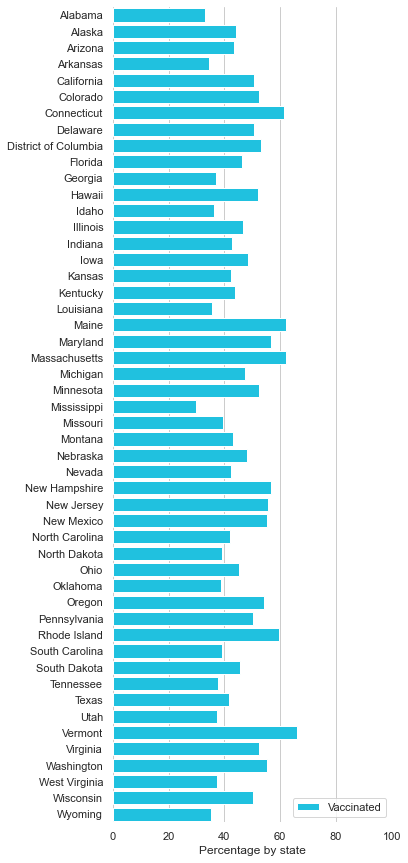

In [51]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 15))


sns.set_color_codes("bright")
sns.barplot(x="%_pop_vaxxed", y="state", data=all3,
            label="Vaccinated", color="c")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Percentage by state")
sns.despine(left=True, bottom=True)

In [12]:
data.head()
data['date'].unique()

xdf = pd.read_csv('us_state_vaccinations.csv')
xdf['date'] = xdf['date'].astype('datetime64[ns]')
xdf.dtypes

#result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()

date                                   datetime64[ns]
location                                       object
total_vaccinations                            float64
total_distributed                             float64
people_vaccinated                             float64
people_fully_vaccinated_per_hundred           float64
total_vaccinations_per_hundred                float64
people_fully_vaccinated                       float64
people_vaccinated_per_hundred                 float64
distributed_per_hundred                       float64
daily_vaccinations_raw                        float64
daily_vaccinations                            float64
daily_vaccinations_per_million                float64
share_doses_used                              float64
dtype: object

In [13]:
xdf = xdf.loc[xdf['date'] >= '2021-1-12']
xdf = xdf.drop(['total_distributed', 'people_vaccinated', 'total_vaccinations_per_hundred', 
                'people_vaccinated_per_hundred', 'distributed_per_hundred', 'daily_vaccinations_raw',
                'daily_vaccinations_per_million', 'share_doses_used'], axis=1)

In [14]:
#dropping uncommon locations
xdf.drop(xdf.index[xdf['location'] == 'Bureau of Prisons'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Republic of Palau'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Veterans Health'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'United States'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Dept of Defense'], inplace = True)
xdf.drop(xdf.index[xdf['location'] == 'Federated States of Micronesia'], inplace = True)                      
xdf.drop(xdf.index[xdf['location'] == 'Indian Health Svc'], inplace = True)            
xdf.drop(xdf.index[xdf['location'] == 'Long Term Care'], inplace = True)                     
xdf.drop(xdf.index[xdf['location'] == 'Marshall Islands'], inplace = True)                              
                     
                     
xdf.head()                     

,date,location,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN
1,2021-01-13,Alabama,84040.0,0.19,9245.0,5906.0
2,2021-01-14,Alabama,92300.0,NaN,NaN,7083.0
3,2021-01-15,Alabama,100567.0,0.28,13488.0,7478.0
4,2021-01-16,Alabama,NaN,NaN,NaN,7498.0


In [15]:
xdf = xdf.sort_values(["date", "location"], ascending = (True, True))

In [16]:
'''
xdf['confirmed'] = np.nan
xdf['cases_avg'] = np.nan
xdf['deaths_avg'] = np.nan
xdf['deaths'] = np.nan
xdf['recovered'] = np.nan
xdf['active'] = np.nan
xdf['incident_rate'] = np.nan
xdf['case_fatality_ratio'] = np.nan
xdf['total_state_pop'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_vaxxed'] = np.nan
xdf['%_pop_infected'] = np.nan
'''
xdf = xdf.rename(columns={"location": "state"}, errors="raise")

xdf.head()


,date,state,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN
176,2021-01-12,Alaska,35838.0,0.74,5400.0,NaN
352,2021-01-12,American Samoa,2124.0,0.47,260.0,NaN
528,2021-01-12,Arizona,141355.0,0.11,8343.0,NaN
704,2021-01-12,Arkansas,40879.0,0.00,8.0,NaN


In [17]:
'''
#retrieving active cases from the confirmed dataframe from the 6th, to be used for an example.

result = confirmed[confirmed['date'] == '2021-07-06']

#retreiving the highest active instances for the day, grouped by state.
result = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
result = result.drop(columns=['index'])
result.head()
'''

"\n#retrieving active cases from the confirmed dataframe from the 6th, to be used for an example.\n\nresult = confirmed[confirmed['date'] == '2021-07-06']\n\n#retreiving the highest active instances for the day, grouped by state.\nresult = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()\nresult = result.drop(columns=['index'])\nresult.head()\n"

In [18]:
#xdf.loc[xdf['date'] == '2021-07-06']

result1 = confirmed[confirmed['date'] <= '2021-07-06']
result1 = result1.loc[(result1['date'] >= '2021-01-12')]
result1 = result1.groupby(['date', 'state']).agg({'Active':np.max}).reset_index()
#result1 = result1.unstack()
#result1 = result1.pivot(index='date', columns='state', values='Active')
#result1 = result1.melt(id_vars=['date', 'state'], value_vars=['Active'])

#result1.loc([result1['date'] == '2021-01-13'])
result1

#retrieving the highest active instances for the day, grouped by state.
#result1 = result.loc[result.groupby('state')['Active'].idxmax(), :].reset_index()
#result1 = result.drop(columns=['index'])
xdf['active'] = np.nan

#result1.head(100)

In [19]:
#xdf['active'] = pd.merge(xdf, result1, on=['date', 'state'])

#result1['state'].unique()

In [20]:
#result1.loc[result1['state'] == 'Alabama']

result1.drop(result1.index[result1['state'] == 'Diamond Princess'], inplace = True)
result1.drop(result1.index[result1['state'] == 'Grand Princess'], inplace = True)
result1 = result1.rename(columns={"Active": "active"}, errors="raise")

In [21]:
xdf = pd.merge(xdf, result1, on=['state','date'])
#xdf['active'] = xdf['active'].interpolate(method='linear', limit_direction='both', limit=1)
#xdf['active'] = xdf['active'].fillna(xdf['active'].mean())
#xdf.dtypes
xdf = xdf.drop(['active_x'], axis=1)
xdf = xdf.rename(columns={"active_y": "active"}, errors="raise")

xdf = xdf.sort_values(by='date')

In [22]:
xdf

,date,state,total_vaccinations,people_fully_vaccinated_per_hundred,people_fully_vaccinated,daily_vaccinations,active
0,2021-01-12,Alabama,78134.0,0.15,7270.0,NaN,59867
30,2021-01-12,Nevada,61653.0,0.28,8761.0,NaN,193483
31,2021-01-12,New Hampshire,50613.0,0.00,5.0,NaN,20952
32,2021-01-12,New Jersey,221045.0,0.16,14306.0,NaN,57609
33,2021-01-12,New Mexico,78235.0,0.54,11335.0,NaN,44923
...,...,...,...,...,...,...,...
9647,2021-07-06,Maryland,6940161.0,56.62,3423288.0,11237.0,85608
9648,2021-07-06,Massachusetts,8910111.0,62.21,4287693.0,12029.0,135478
9649,2021-07-06,Michigan,9468301.0,47.35,4728832.0,8119.0,166192
9651,2021-07-06,Mississippi,1913816.0,29.89,889553.0,1047.0,22438


In [23]:
'''
xdf = xdf.reset_index()
#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)
xdf = xdf.drop(['index'],axis=1)
#xdf = xdf.drop(['level_0'],axis=1)
'''

"\nxdf = xdf.reset_index()\n#xdf['daily_vaccinations'] = xdf['daily_vaccinations'].interpolate(method='linear', limit_direction='backward', limit=1)\nxdf = xdf.drop(['index'],axis=1)\n#xdf = xdf.drop(['level_0'],axis=1)\n"

In [24]:
'''
xdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())
xdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()
xdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())
xdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()
xdf['active'] = xdf['active'].interpolate()
xdf.head(57)
'''

"\nxdf['daily_vaccinations'] = xdf['daily_vaccinations'].fillna(xdf['daily_vaccinations'].mean())\nxdf['total_vaccinations'] = xdf['total_vaccinations'].interpolate()\nxdf['people_fully_vaccinated_per_hundred'] = xdf['people_fully_vaccinated_per_hundred'].fillna(xdf['people_fully_vaccinated_per_hundred'].mean())\nxdf['people_fully_vaccinated'] = xdf['people_fully_vaccinated'].interpolate()\nxdf['active'] = xdf['active'].interpolate()\nxdf.head(57)\n"

In [25]:
#accessing 6 months of data from JH github
jHdata = []
dates=[datetime.date(2021,1,11)+datetime.timedelta(dval) for dval in range(0,176)];
for dateval in dates:
    jdata = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/"+dateval.strftime('%m-%d-%Y')+".csv"
    jdownl = requests.get(jdata).content
    #Loading data into list
    j_temp = pd.read_csv(io.StringIO(jdownl.decode('utf-8')))
    jHdata.append(j_temp)
    
    #all data into an array in order to create dataframe
jArr = np.array(jHdata)
jArr = jArr.reshape(-1,18)
j_data = pd.DataFrame(jArr, columns=['Province_State', 'Country_Region','Last_Update', 'Lat', 'Long_',
                                     'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS',
                                       'Incident_Rate', 'Total_Test_Results','People_Hospitalized',
                                     'Case_Fatality_Ratio', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate'])

j_data['date'] = pd.to_datetime(j_data['Last_Update'], format='%Y-%m-%d').dt.date
j_data['date'] = pd.to_datetime(j_data['date'], format='%Y-%m-%d')
j_data['state'] = j_data['Province_State']

#dropping uncommon states
j_data.drop(j_data.index[j_data['state'] == 'Diamond Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Grand Princess'], inplace = True)
j_data.drop(j_data.index[j_data['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating the needed data into a new dataframe
j_new = j_data.drop(columns = ['Last_Update','Province_State','Country_Region','Lat', 'Long_','Recovered','Active',
                               'FIPS', 'Total_Test_Results', 'People_Hospitalized', 'UID', 'ISO3', 
                           'Testing_Rate', 'Hospitalization_Rate'])
j_new = j_new.sort_values(by='date')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].astype(float, errors = 'raise')
j_new['Case_Fatality_Ratio'] = j_new['Case_Fatality_Ratio'].interpolate(method='linear')
display(j_new.dtypes)
j_new.isnull().sum()

Confirmed                      object
Deaths                         object
Incident_Rate                  object
Case_Fatality_Ratio           float64
date                   datetime64[ns]
state                          object
dtype: object

Confirmed              0
Deaths                 0
Incident_Rate          0
Case_Fatality_Ratio    0
date                   0
state                  0
dtype: int64

In [26]:
#accessing 6 months of data from NYT github
urlN = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us-states.csv" 
downloadN = requests.get(urlN).content

#Creating a new dataframe for rolling average values

rolling_avgN = pd.read_csv(io.StringIO(downloadN.decode('utf-8')))

rolling_avgN['date'] = pd.to_datetime(rolling_avgN['date'], format='%Y-%m-%d')
rolling_avgN.drop(rolling_avgN.index[rolling_avgN['state'] == 'Virgin Islands'], inplace = True)

#Extrapolating needed data into a new rolling average dataframe.
rolling_avgN = rolling_avgN.drop(columns = ['geoid', 'cases', 'deaths', 'deaths_avg_per_100k'])

rolling_avgTemp = rolling_avgN.loc[(rolling_avgN['date'] >='2021-01-12')]
raN2 = rolling_avgTemp.loc[(rolling_avgTemp['date'] <='2021-07-06')]

display(raN2)
#raN2 = raN2.sort_values(by='date')

,date,state,cases_avg,cases_avg_per_100k,deaths_avg
17339,2021-01-12,Northern Mariana Islands,0.86,1.59,0.00
17340,2021-01-12,Guam,10.29,6.10,0.14
17341,2021-01-12,Puerto Rico,729.71,21.54,11.86
17343,2021-01-12,Wyoming,357.57,61.78,8.29
17344,2021-01-12,Wisconsin,3337.00,57.31,37.86
...,...,...,...,...,...
27014,2021-07-06,California,1504.40,3.81,32.20
27015,2021-07-06,Arkansas,485.14,16.08,3.00
27016,2021-07-06,Arizona,543.43,7.47,10.00
27017,2021-07-06,Alaska,27.57,3.77,0.43


In [27]:
#Merging 2 Dataframes together
twoD = pd.merge(raN2, xdf, on=['date', 'state'])
twoD
print(twoD.dtypes)
twoD['date'] = pd.to_datetime(twoD['date'], format='%Y-%m-%d')

#Merging the Created dataframe and the master data together
tres = pd.merge(twoD, j_new, on=['date', 'state'])

tres = tres[['date','state', 'people_fully_vaccinated', 'Confirmed','cases_avg', 'deaths_avg','Deaths', 
             'Incident_Rate', 'Case_Fatality_Ratio', 'daily_vaccinations','total_vaccinations']]

#doing the math for recovered
tres['Recovered'] = tres['Confirmed'] - tres['Deaths']


#Displaying the new merged dataframe
tres = tres.sort_values(by=['date'])
tres

date                                   datetime64[ns]
state                                          object
cases_avg                                     float64
cases_avg_per_100k                            float64
deaths_avg                                    float64
total_vaccinations                            float64
people_fully_vaccinated_per_hundred           float64
people_fully_vaccinated                       float64
daily_vaccinations                            float64
active                                          int64
dtype: object


,date,state,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,Recovered
0,2021-01-12,Northern Mariana Islands,331.0,128,0.86,0.00,2,232.119542,1.562500,NaN,3722.0,126
29,2021-01-12,Minnesota,9798.0,437552,1945.00,38.86,5779,7758.520414,1.320757,NaN,162240.0,431773
30,2021-01-12,Michigan,19472.0,567682,3375.00,98.29,14192,5684.290863,2.499991,NaN,227685.0,553490
31,2021-01-12,Massachusetts,19073.0,437042,6475.29,77.00,13206,6279.329875,3.038565,NaN,204082.0,423836
32,2021-01-12,Maryland,6663.0,309686,3229.57,40.71,6301,5122.434532,2.034642,NaN,146231.0,303385
...,...,...,...,...,...,...,...,...,...,...,...,...
9296,2021-07-06,New Mexico,1157532.0,205715,61.57,1.14,4344,9810.766639,2.111659,9062.0,2404087.0,201371
9297,2021-07-06,New Jersey,4955488.0,1024311,180.71,4.71,26477,11532.189696,2.584859,17281.0,9940163.0,997834
9298,2021-07-06,New Hampshire,771557.0,99555,20.71,0.29,1372,7321.776466,1.378133,4673.0,1547687.0,98183
9286,2021-07-06,Tennessee,2572522.0,867407,190.57,3.71,12571,12701.492157,1.449262,33323.0,5496489.0,854836


In [28]:
tres['daily_vaccinations'] = tres['daily_vaccinations'].interpolate(method='linear', limit_direction='backward')
tres = tres.sort_values(["date", "state"], ascending = (True, True))
tres['active'] = xdf['active']
tres['active'] = round(tres['active'], 2)
tres['total_state_pop'] = np.nan
tres['total_state_pop'] = tres['total_state_pop'].fillna(tres.state.map(dict(zip(state_df.state, state_df.population_est))))
tres['%_pop_vaxxed'] = round((tres['people_fully_vaccinated'] / tres['total_state_pop']) *100, 2)
tres['%_pop_infected'] = round((tres['active'] / tres['total_state_pop']) *100, 2)
tres['Case_Fatality_Ratio'] = round(tres['Case_Fatality_Ratio'], 2)

tres['Confirmed'] = tres['Confirmed'].astype(np.float64)
tres['Deaths'] = tres['Deaths'].astype(np.float64)
tres['Incident_Rate'] = tres['Incident_Rate'].astype(np.float64)
tres['Recovered'] = tres['Recovered'].astype(np.float64)
tres['Incident_Rate'] = round(tres['Incident_Rate'], 2)

tres.isna().sum()

date                         0
state                        0
people_fully_vaccinated    392
Confirmed                    0
cases_avg                    0
deaths_avg                   0
Deaths                       0
Incident_Rate                0
Case_Fatality_Ratio          0
daily_vaccinations           0
total_vaccinations         318
Recovered                    0
active                       0
total_state_pop            528
%_pop_vaxxed               889
%_pop_infected             528
dtype: int64

In [29]:
tres['people_fully_vaccinated'] = tres['people_fully_vaccinated'].interpolate(method='linear', limit_direction='both')
tres['total_vaccinations'] = tres['total_vaccinations'].interpolate(method='linear', limit_direction='both')
tres['total_state_pop'] = tres['total_state_pop'].interpolate(method='linear', limit_direction='both')
tres['%_pop_vaxxed'] = tres['%_pop_vaxxed'].interpolate(method='linear', limit_direction='both')
tres['%_pop_infected'] = tres['%_pop_infected'].interpolate(method='linear', limit_direction='both')

tres.isna().sum()

date                       0
state                      0
people_fully_vaccinated    0
Confirmed                  0
cases_avg                  0
deaths_avg                 0
Deaths                     0
Incident_Rate              0
Case_Fatality_Ratio        0
daily_vaccinations         0
total_vaccinations         0
Recovered                  0
active                     0
total_state_pop            0
%_pop_vaxxed               0
%_pop_infected             0
dtype: int64

In [30]:
tres.shape

(9328, 16)

In [31]:
tres = tres.reset_index(drop=True)
#tres.drop(['index','level_0'], axis=1, inplace=True)
tres

,date,state,people_fully_vaccinated,Confirmed,cases_avg,deaths_avg,Deaths,Incident_Rate,Case_Fatality_Ratio,daily_vaccinations,total_vaccinations,Recovered,active,total_state_pop,%_pop_vaxxed,%_pop_infected
0,2021-01-12,Alabama,7270.0,404000.0,4036.43,76.83,5347.0,8239.54,1.32,13402.0,78134.0,398653.0,9853,4903185.0,0.15,0.20
1,2021-01-12,Alaska,5400.0,50413.0,277.29,1.00,224.0,6888.71,0.44,13402.0,35838.0,50189.0,70545,731545.0,0.74,9.64
2,2021-01-12,Arizona,8343.0,627541.0,9580.43,169.00,10147.0,8621.59,1.62,13402.0,141355.0,617394.0,50278,7278717.0,0.11,0.69
3,2021-01-12,Arkansas,8.0,256344.0,2952.14,40.71,4081.0,8494.39,1.59,13402.0,40879.0,252263.0,2166,3017804.0,0.00,0.07
4,2021-01-12,California,100089.0,2784716.0,43491.86,517.00,30519.0,6980.17,1.11,13402.0,816301.0,2754197.0,3261,39512223.0,0.25,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,2021-07-06,Virginia,4478317.0,681194.0,180.14,3.14,11431.0,7980.70,1.68,16147.0,9328521.0,669763.0,99424,8535519.0,52.47,1.16
9324,2021-07-06,Washington,4206349.0,452483.0,331.86,6.86,5939.0,5942.08,1.31,19116.0,8676836.0,446544.0,18445,7614893.0,55.24,0.24
9325,2021-07-06,West Virginia,671593.0,164149.0,41.00,1.67,2899.0,9159.35,1.77,1529.0,1426490.0,161250.0,154545,1792147.0,37.47,8.62
9326,2021-07-06,Wisconsin,2930845.0,678008.0,73.86,2.57,8144.0,11644.75,1.20,11972.0,5982183.0,669864.0,40558,5822434.0,50.34,0.70


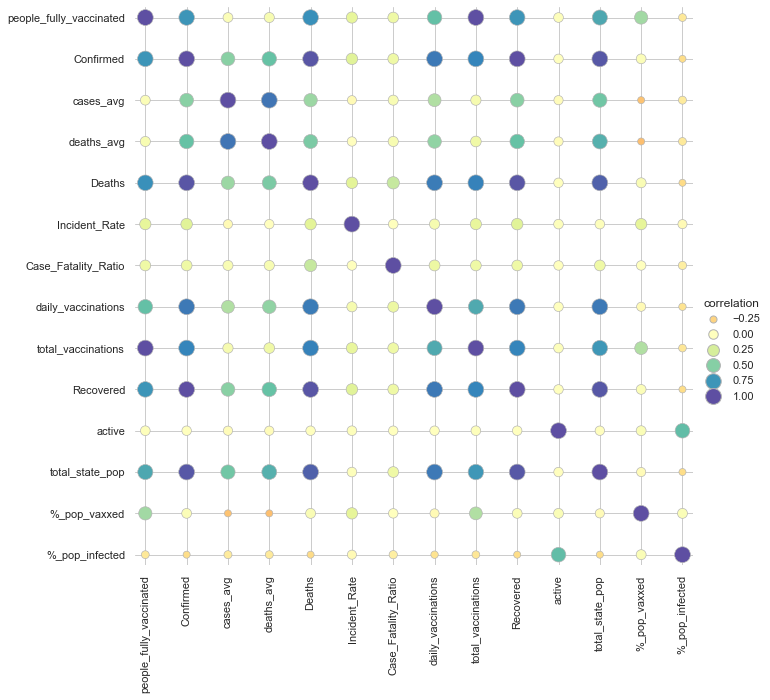

In [56]:
# Visualization of correlation matrix
corr_mat = tres.corr().stack().reset_index(name="correlation")

g = sns.relplot(
    data=corr_mat,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="Spectral", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

In [58]:
# reading travel change data
tch = pd.read_csv('TravelChangeData.csv')
# dropping military airports
tch = tch[~tch['Airport'].str.contains(r'NAF|AFS|AFB|AAF|MCAS')]
# dropping cols with no passenger info
tch = tch.drop(columns = ['Airport Country Name', 'Origin Airport Id', 'Origin State Abr', 'Freight tons', 'Latitude', 
                          'Longitude','Mail tons', 'Display City Market Name Full'])
# creating separate dataframes for each year's data
ptd = tch[tch['Year']== 2019].drop(columns = 'Year')
ptd = ptd.rename(columns={"Passengers": "Passengers 2019"})
ntd = tch[tch['Year'] == 2020].drop(columns = 'Year')
ntd = ntd.rename(columns={"Passengers": "Passengers 2020"})

#merging to compare years
ychd = pd.merge(ptd, ntd, on=['State' , 'Code', 'Airport', 'City'])
ychd = ychd.sort_values(by='State')
ychd.isnull().sum()

ychd['Passengers 2019'] = ychd['Passengers 2019'].interpolate(method='linear')
ychd['Passengers 2020'] = ychd['Passengers 2020'].interpolate(method='linear')

# summing values for each airport in each state
sych = ychd.drop(columns = ['Airport', 'City', 'Code'])
sych = sych.groupby(by='State').sum()
sych['Difference'] = sych['Passengers 2019'] - sych['Passengers 2020']
sych = sych.reset_index()
sych

,State,Passengers 2019,Passengers 2020,Difference
0,Alabama,2645096.0,797473.0,1847623.0
1,Alaska,3814742.5,1401341.0,2413401.5
2,Arizona,24850629.0,8880647.0,15969982.0
3,Arkansas,2040658.0,637534.0,1403124.0
4,California,104403549.0,28279957.0,76123592.0
5,Colorado,33755789.0,12214950.0,21540839.0
6,Connecticut,3278835.0,908505.0,2370330.0
7,Delaware,437.0,78.0,359.0
8,Florida,85959740.0,30538870.0,55420870.0
9,Georgia,54271290.0,15752656.0,38518634.0


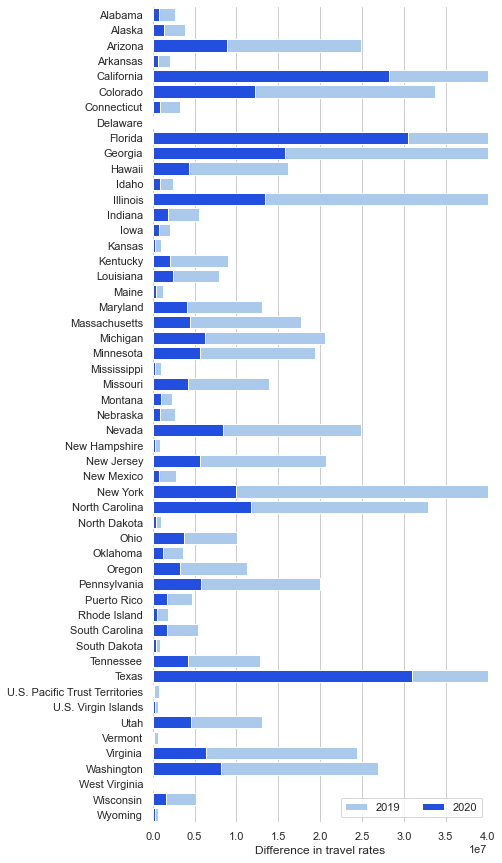

In [57]:
# Visualization of difference in number of travelers before and during the pandemic
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 15))


sns.set_color_codes("pastel")
sns.barplot(x="Passengers 2019", y="State", data=sych,
            label="2019", color="b")


sns.set_color_codes("bright")
sns.barplot(x="Passengers 2020", y="State", data=sych,
            label="2020", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 40000000), ylabel="",
       xlabel="Difference in travel rates")
sns.despine(left=True, bottom=True)



In [34]:
#gdf = geopandas.GeoDataFrame(
#    sych, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

In [35]:
# reading travel purpose data
tpd = pd.read_csv('TravelPurposeData.csv')
tpd = tpd[tpd['Year']== 2017].drop(columns=['Number of Records'])
tpd = tpd.drop(columns =['Year'])
tpd.drop(tpd.index[tpd['State'] == 'United States'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Other'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'School/Church'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Social/Recreational'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work-related'], inplace = True)
tpd.drop(tpd.index[tpd['Trip Purpose'] == 'Work'], inplace = True)
tpd = tpd.drop(columns=['Trip Purpose', 'Number of Trips', 'Person miles (millions)', 'Person trips (millions)'])
tpd = tpd.rename(columns = {'Persons (thousands)': 'Travelers 2017'})
tpd['Travelers 2017'] = tpd['Travelers 2017'].astype('float64') * 1000
tpd.isnull().sum()
tpd

,State,Travelers 2017
528,Alabama,4466000.0
534,Alaska,686000.0
540,Arizona,6382000.0
546,Arkansas,3084000.0
552,California,36632000.0
558,Colorado,4716000.0
564,Connecticut,2952000.0
570,Delaware,914000.0
576,District of Columbia,1241000.0
582,Florida,17719000.0


In [36]:
#merging both travel datasets together
trav = pd.merge(sych, tpd, on = ['State'])
trav

,State,Passengers 2019,Passengers 2020,Difference,Travelers 2017
0,Alabama,2645096.0,797473.0,1847623.0,4466000.0
1,Alaska,3814742.5,1401341.0,2413401.5,686000.0
2,Arizona,24850629.0,8880647.0,15969982.0,6382000.0
3,Arkansas,2040658.0,637534.0,1403124.0,3084000.0
4,California,104403549.0,28279957.0,76123592.0,36632000.0
5,Colorado,33755789.0,12214950.0,21540839.0,4716000.0
6,Connecticut,3278835.0,908505.0,2370330.0,2952000.0
7,Delaware,437.0,78.0,359.0,914000.0
8,Florida,85959740.0,30538870.0,55420870.0,17719000.0
9,Georgia,54271290.0,15752656.0,38518634.0,9563000.0
